In [11]:
from datetime import datetime
import pandas as pd
import numpy as np
from datetime import datetime
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [12]:
df_data = pd.read_excel('data')
#clean data
df_clean = df_data[['Agent Coordinates','Quantity','Order Line Total']]
#15 orders were dropped because they did not have delievery location
df_clean = df_clean[df_clean['Agent Coordinates'] !=' ']

#Find unique delivery locations for all orders
df_orders = df_clean.groupby(['Agent Coordinates']).sum()
df_orders.reset_index(inplace=True)


df_orders = df_orders.rename(columns={#'Order ID':'ID',
                  'Quantity':'QTY',
                  'Agent Coordinates':'Coordinates',
                  'Order Line Total':'Total'})

#removed to make graph pretty
df_orders = df_orders[df_orders['Coordinates'] != '0.00000000 0.00000000']

In [3]:
def create_data_model():
  #make location data
  data = {}
  locations_ = []
  for coordinate in df_orders.Coordinates.to_list():
    lst_coordinate = coordinate.split(' ')
    if len(lst_coordinate) == 3:
      locations_.append((float(lst_coordinate[1]),float(lst_coordinate[2])))
    elif len(lst_coordinate) == 2:
      locations_.append((float(lst_coordinate[0]),float(lst_coordinate[1])))
    else:
      continue

  assert len(locations_) == df_orders.shape[0]

  #I use the same distance conversion from the previous model, I will need specifics about how the coordinates works later
  # here we use: 114m x 80m city block
  # src: https://nyti.ms/2GDoRIe "NY Times: Know Your distance"
  data['locations'] = [(l[0] * 114, l[1] * 80) for l in locations_]


  data['num_vehicles'] = 17

  #set up Depo which i assume is in the middle of all the delivery points
  depo = np.array(data['locations']).mean(axis=0)

  #data['locations'].insert(0, (depo[0],depo[1]))
  #data['depot'] = 0

  data['numlocations_'] = len(data['locations'])


  def manhattan_distance(position_1, position_2):
    """Computes the Manhattan distance between two points."""
    return (abs(position_1[0] - position_2[0]) +
            abs(position_1[1] - position_2[1]))

  def create_distance_matrix(coords):
      n = len(coords)
      dist_matrix = [[0] * n for i in range(n)]
      for i in range(n):
          for j in range(i+1, n):
              dist = manhattan_distance(coords[i], coords[j])
              dist_matrix[i][j] = dist
              dist_matrix[j][i] = dist
      return dist_matrix
  data['distance_matrix'] = create_distance_matrix(data['locations'])
  
  return data

data = create_data_model()

In [13]:
depo = np.array(data['locations']).mean(axis=0)
data['locations'].insert(0, (depo[0],depo[1]))
#this gives the coordinates of each delivery location
costs = np.array(data['locations'])
yc = costs[:,1]
xc = costs[:,0]

data['locations'].pop(0)

location_ID = [i for i in range(1,1+len(data['locations']))]
#0 is depo
nodes = [0] + location_ID

arcs = [(i, j) for i in nodes for j in nodes if i != j]

arc_cost = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in arcs}

vehicle_capacity = [500, 20, 

d = df_orders.QTY.to_list()
d.insert(0,0)
demand ={i: int(d[i]) for i in location_ID}

In [14]:
from gurobipy import Model, GRB, quicksum
mdl = Model('CVRP')

In [15]:

x = mdl.addVars(arcs, vtype=GRB.BINARY, name = 'arc')
u = mdl.addVars(location_ID, vtype=GRB.CONTINUOUS, name = 'location_id')
mdl.modelSense = GRB.MINIMIZE

#cost calculation
mdl.setObjective(quicksum(x[i, j]*arc_cost[i, j] for i, j in arcs))

#setting up leaving and entering node
mdl.addConstrs(quicksum(x[i, j] for j in nodes if j != i) == 1 for i in location_ID)
mdl.addConstrs(quicksum(x[i, j] for i in nodes if i != j) == 1 for j in location_ID)

#demand constraint
mdl.addConstrs((x[i, j] == 1) >> (u[i]+demand[j] == u[j])
               for i, j in arcs if i != 0 and j != 0)
#capacity constrain
mdl.addConstrs(u[i] >= demand[i] for i in location_ID)
mdl.addConstrs(u[i] <= vehicle_capacity for i in location_ID)

if u < mini then something like 

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

In [16]:
mdl.Params.MIPGap = 0.95
mdl.optimize()

Set parameter MIPGap to value 0.95
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2576 rows, 416024 columns and 830760 nonzeros
Model fingerprint: 0x9bda8729
Model has 414092 general constraints
Variable types: 644 continuous, 415380 integer (415380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
  GenCon rhs range [1e+00, 2e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 1288 rows and 0 columns (presolve time = 5s) ...
Presolve removed 829472 rows and 828184 columns (presolve time = 10s) ...
Presolve added 826896 rows and 0 columns
Presolve time: 12.18s
Presolved: 829472 rows, 416024 columns, 3314024 nonzeros
Variable types: 644 continuous, 415380 integer (415380 binary)
Found heuristic solution: objective 11001.015284


In [17]:
active_arcs = [a for a in arcs if x[a].x > 0.99]

In [18]:
for i,j in active_arcs:
    print([xc[i], xc[j]], [yc[i], yc[j]])

[-141.39877510677022, -128.31959700000002] [2949.7709788136635, 2960.5221039999997]
[-141.39877510677022, -135.3978] [2949.7709788136635, 2952.4]
[-141.39877510677022, -136.881282] [2949.7709788136635, 2952.2427040000002]
[-141.39877510677022, -137.4612] [2949.7709788136635, 2951.792]
[-141.39877510677022, -140.8812] [2949.7709788136635, 2933.776]
[-141.39877510677022, -141.5196] [2949.7709788136635, 2951.6879999999996]
[-141.39877510677022, -141.8722248] [2949.7709788136635, 2951.1046800000004]
[-141.39877510677022, -142.19961] [2949.7709788136635, 2950.2932]
[-141.39877510677022, -142.2378] [2949.7709788136635, 2950.3680000000004]
[-141.39877510677022, -146.12463] [2949.7709788136635, 2952.401336]
[-141.39877510677022, -146.20499999999998] [2949.7709788136635, 2940.128]
[-141.39877510677022, -146.27339999999998] [2949.7709788136635, 2952.0960000000005]
[-141.39877510677022, -146.3246544] [2949.7709788136635, 2939.600656]
[-141.39877510677022, -146.4444] [2949.7709788136635, 2938.704]

Plot of all routes given the constraints

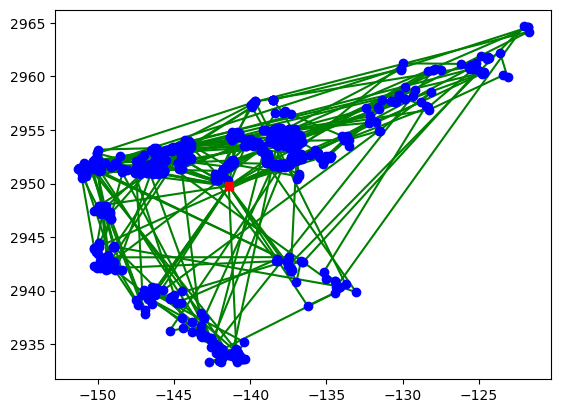

In [19]:
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:-1], yc[1:-1], c='b')